In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import os

## **Utilities**

In [11]:
# Saving results
def save_image(image, file_path, c='gray'):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.imsave(file_path, image, cmap=c)
    
# Plotting resuklts
def plot_results(gray, binary_image, labeled_image, num_objects, path):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    ax = axes.ravel()

    ax[0].imshow(gray, cmap='gray')
    ax[0].set_title('Grayscale Image')
    save_image(gray, file_path=f'{path.split(".")[0]}/Grayscale-Image-{path.split(".")[0]}.png')

    ax[1].imshow(binary_image, cmap='gray')
    ax[1].set_title('Binary Image')
    save_image(binary_image, file_path=f'{path.split(".")[0]}/Binary-Image-{path.split(".")[0]}.png')

    ax[2].imshow(labeled_image, cmap='nipy_spectral')
    ax[2].set_title(f'Labeled Image - {num_objects} Objects')
    save_image(labeled_image, file_path=f'{path.split(".")[0]}/Labeled-Image-{path.split(".")[0]}.png', c='nipy_spectral')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

## **Image processing functions**

In [12]:
def rgb_to_gray(rgb_image):
    if rgb_image.ndim == 3:
        r_coeff = 0.299
        g_coeff = 0.587
        b_coeff = 0.114
        gray_image = np.dot(rgb_image[...,:3], [r_coeff, g_coeff, b_coeff])
        return gray_image
    return f'The image has only {rgb_image.ndim}'

def gray_to_binary(image):
    if (image.min() and image.max) in range(0,1):
        binary_image = image > 0.5
    else:
        image = image/255.0
        binary_image = image > 0.5 
    return binary_image

# Function for findin threshold for binarization using otsu's method
def otsu_threshold(image):
    min_value = np.min(image)
    max_value = np.max(image)
    # Compute histogram of the grayscale image
    hist, bin_edges = np.histogram(image, bins=256, range=(min_value, max_value))
    
    total = hist.sum()
    current_max, threshold = 0, 0
    sum_total, sum_background = 0, 0
    weight_background, weight_foreground = 0, 0

    for i in range(0, len(hist)):
        sum_total += i * hist[i]
    
    for i in range(0, len(hist)):
        weight_background += hist[i]
        if weight_background == 0:
            continue
        weight_foreground = total - weight_background
        if weight_foreground == 0:
            break
        sum_background += i * hist[i]
        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground
        between_class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        if between_class_variance > current_max:
            current_max = between_class_variance
            threshold = i
    
    return bin_edges[threshold]

## **Operations**

In [13]:
# Structuring element
def disk(radius):
    L = np.arange(-radius, radius+1)
    X, Y = np.meshgrid(L, L)
    return (X**2 + Y**2) <= radius**2

# Erosion
def binary_erosion(image, selem):
    pad_width = selem.shape[0] // 2
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+selem.shape[0], j:j+selem.shape[1]]
            output[i, j] = np.min(region[selem])
    return output

# Dilation
def binary_dilation(image, selem):
    pad_width = selem.shape[0] // 2
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+selem.shape[0], j:j+selem.shape[1]]
            output[i, j] = np.max(region[selem])
    return output

def binary_opening(image, selem):
    eroded = binary_erosion(image, selem)
    return binary_dilation(eroded, selem)

def binary_closing(image, selem):
    dilated = binary_dilation(image, selem)
    return binary_erosion(dilated, selem)

## **Advanced Operations**

In [14]:
# Zhang-Suen thinning algorithm
def skeletonization(binary_image):
    skeleton = np.zeros(binary_image.shape, dtype=np.uint8)
    skeleton[binary_image == 1] = 255  
    skeleton_changed = True
    while skeleton_changed:
        skeleton_changed = False
        to_delete = []
        for i in range(1, binary_image.shape[0] - 1):
            for j in range(1, binary_image.shape[1] - 1):
                if (skeleton[i, j] == 255 and
                    2 <= np.sum(skeleton[i-1:i+2, j-1:j+2] // 255) <= 6 and  
                    skeleton[i-1, j-1] == 0 and skeleton[i-1, j] == 0 and skeleton[i-1, j+1] == 0 and
                    skeleton[i, j-1] == 0 and skeleton[i, j+1] == 0 and
                    skeleton[i+1, j-1] == 0 and skeleton[i+1, j] == 0 and skeleton[i+1, j+1] == 0):
                    to_delete.append((i, j))
        for (i, j) in to_delete:
            skeleton[i, j] = 0
            skeleton_changed = True
        to_delete = []
        for i in range(1, binary_image.shape[0] - 1):
            for j in range(1, binary_image.shape[1] - 1):
                if (skeleton[i, j] == 255 and
                    2 <= np.sum(skeleton[i-1:i+2, j-1:j+2] // 255) <= 6 and  
                    skeleton[i-1, j] == 0 and skeleton[i, j-1] == 0 and skeleton[i+1, j] == 0):
                    to_delete.append((i, j))
        for (i, j) in to_delete:
            skeleton[i, j] = 0
            skeleton_changed = True
    skeleton[binary_image == 1] = 1
    return skeleton

In [15]:
# Extract boundary by subtracting eroded image from original binary image
def extract_boundary(binary_image, structuring_element):
    eroded_image = binary_erosion(binary_image, structuring_element)
    boundary_image = binary_image - eroded_image
    return boundary_image

In [16]:
def label_regions(binary_image, structuring_element):
    labeled_image = np.zeros_like(binary_image)
    current_label = 1  
    labels = {}  
    for r in range(binary_image.shape[0]):
        for c in range(binary_image.shape[1]):
            if binary_image[r, c] == 1 and labeled_image[r, c] == 0:
                labeled_image[r, c] = current_label
                stack = [(r, c)]
                while stack:
                    current_pixel = stack.pop()
                    neighbors = [(current_pixel[0]-1, current_pixel[1]),
                                 (current_pixel[0]+1, current_pixel[1]),
                                 (current_pixel[0], current_pixel[1]-1),
                                 (current_pixel[0], current_pixel[1]+1)]
                    for neighbor in neighbors:
                        nr, nc = neighbor
                        if 0 <= nr < binary_image.shape[0] and 0 <= nc < binary_image.shape[1]:
                            if binary_image[nr, nc] == 1 and labeled_image[nr, nc] == 0:
                                labeled_image[nr, nc] = current_label
                                stack.append((nr, nc))
                labels[current_label] = current_label
                current_label += 1
    for label in labels:
        labeled_image[labeled_image == label] = labels[label]
    
    num_labels = len(labels)
    return labeled_image, num_labels

In [17]:
# Connected component labeling
def connected_components(binary_img):
    labeled_img = np.zeros(binary_img.shape, dtype=int)
    label = 0
    max_label = 0
    equivalences = []
    
    for r in range(1, binary_img.shape[0]-1):
        for c in range(1, binary_img.shape[1]-1):
            if binary_img[r, c] == 1:
                neighbors = [labeled_img[r-1, c], labeled_img[r, c-1], labeled_img[r-1, c-1], labeled_img[r-1, c+1]]
                non_zero_neighbors = [label for label in neighbors if label > 0]
                
                if not non_zero_neighbors:
                    label += 1
                    labeled_img[r, c] = label
                else:
                    min_label = min(non_zero_neighbors)
                    labeled_img[r, c] = min_label
                    for neighbor in non_zero_neighbors:
                        if neighbor != min_label:
                            equivalences.append((neighbor, min_label))
    
    # Resolve equivalences
    def resolve_label(label, equivalence_dict):
        while label in equivalence_dict:
            label = equivalence_dict[label]
        return label
    
    equivalence_dict = {a: b for a, b in equivalences}
    for r in range(binary_img.shape[0]):
        for c in range(binary_img.shape[1]):
            if labeled_img[r, c] > 0:
                labeled_img[r, c] = resolve_label(labeled_img[r, c], equivalence_dict)
    
    unique_labels = np.unique(labeled_img)
    num_objects = len(unique_labels[unique_labels > 0])
    
    return labeled_img, num_objects

## **Image Segmentation and Object Counting**

**Objective**: Segment objects in image and count the number of distinct objects present.

### **Example 1: Segmenting and Counting Stones**

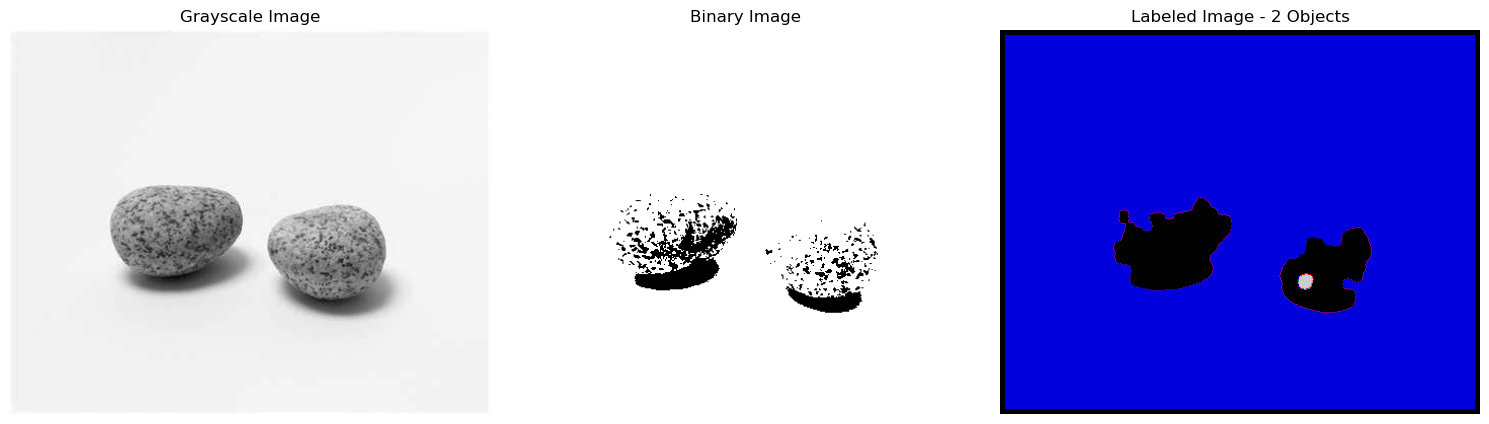

Number of distinct objects: 2


In [18]:
# Loadin image
path = 'Stones.jpeg'
image = plt.imread(path)

# Grayscale conversion
gray = rgb_to_gray(image)

# Binary conversion
binary_image = gray_to_binary(gray)

# Structuring element
selem = disk(5)

# Opening to remove small noise
opened_image = binary_opening(binary_image, selem)

# Closing to close small holes inside objects
closed_image = binary_closing(opened_image, selem)

# Labeled image and number of objects
labeled_image, num_objects = connected_components(closed_image)

plot_results(gray, binary_image, labeled_image, num_objects, path=path)

print(f'Number of distinct objects: {num_objects}')

### **Example 2: Sgementing and Counting Rice Grains**

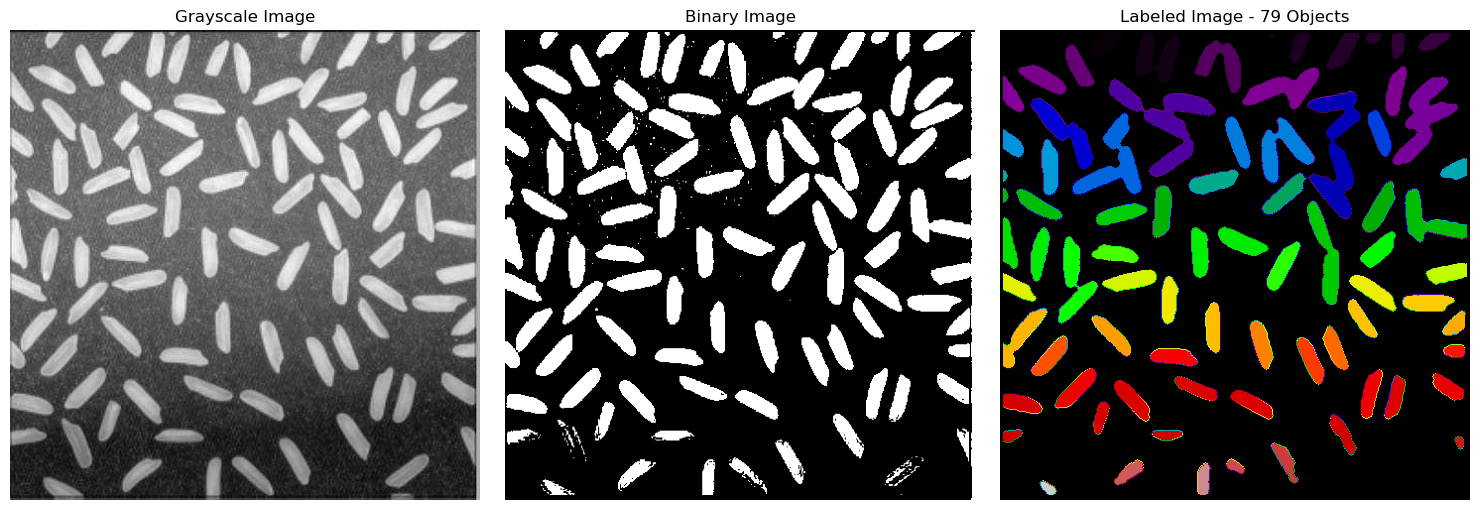

Number of distinct objects: 79


In [19]:
# Loadin image
path = 'rice.jpeg'
image = plt.imread(path)

# Grayscale conversion
gray = rgb_to_gray(image)

# Binary conversion
binary_image = gray_to_binary(gray)

# Structuring element
selem = disk(3)

# Opening to remove small noise
opened_image = binary_opening(binary_image, selem)

# Closing to close small holes inside objects
closed_image = binary_closing(opened_image, selem)

# Labeled image and number of objects
labeled_image, num_objects = connected_components(closed_image)

plot_results(gray, binary_image, labeled_image, num_objects, path=path)

print(f'Number of distinct objects: {num_objects}')